In [1]:
from functools import partial
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

from swimnetworks import Linear
from swimpde.ansatz import BasicAnsatz
from swimpde.domain import Domain

Set parameters of the equation

In [2]:
a_ratio = 8.8131
Cv = 75.2629
theta_fiber = 0
theta0 = np.pi/2 - theta_fiber
a = np.array([np.cos(theta0), np.sin(theta0)]).T
b = np.array([np.cos(theta0-np.pi/2), np.sin(theta0-np.pi/2)]).T
D = ( (1/a_ratio)*np.tensordot( a, a,  axes=0) + np.tensordot( b, b,  axes=0)  )

Create data for training and evaluation

In [3]:
# Evaluation data to test the results on.
n_test_sqrt = 101
x_span = -2, 2
n_dim = 2

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1)
xy_test = xy_test.reshape(-1, n_dim)

In [4]:
# Measurement points to use for training.
n_measurement_points = 20

u_measured = np.load("datasets/recordedtimes.npy").reshape(-1, 1)
xy_measurement = np.load("datasets/locations.npy")

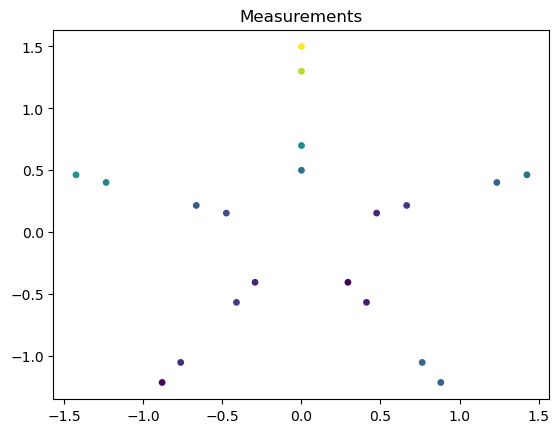

In [8]:

# Plot the measurements.
plt.scatter(*xy_measurement.T, c=u_measured, s=15)
plt.title("Measurements");


In [15]:
# Domain data
n_col_sqrt = 50

x_col = np.linspace(*x_span, num=n_col_sqrt)
y_col = np.linspace(*x_span, num=n_col_sqrt)
xy_col = np.stack(np.meshgrid(x_col, y_col), axis=-1)
xy_col = xy_col.reshape(-1, n_dim)

In [16]:
xy_col.shape

(2500, 2)

Define networks to model u and gamma

In [17]:
n_basis = 400
u_seed = 99

def get_model(points, target, n_basis, seed):
    domain = Domain(interior_points=points)
    ansatz = BasicAnsatz(n_basis=n_basis,
                         activation="tanh",
                         random_seed=seed)
    ansatz.fit(domain, target)
    linear = Linear(regularization_scale=1e-12)
    if target is not None:
        weights = np.linalg.lstsq(
            ansatz.transform(points), target, rcond=1e-12
            )[0]
        linear.weights = weights
    linear.biases = np.zeros((1, 1))
    linear.layer_width = 1
    return ansatz, linear

u_ansatz, u_linear = get_model(xy_measurement, u_measured, n_basis, u_seed)

Run the alternating least squares to solve the bilinear problem

In [ ]:
n_iters = 1


training_start = time()
for _ in range(n_iters):
    u_phi_measured = u_ansatz.transform(xy_measurement)
    u_phi = u_ansatz.transform(xy_col)
    u_approx = u_linear.transform(u_phi)
    u_phi_xx = u_ansatz.transform(xy_col, operator="grad")

    # Least Squares for computing gamma
    matrix_in_gamma = gamma_phi * u_approx
    matrix_out_gamma = u_phi_xx @ u_linear.weights - 1
    gamma_outer_weights = np.linalg.lstsq(
        matrix_in_gamma, matrix_out_gamma, rcond=1e-12
    )[0]

    # Least squares for computing u_approx: use updated value of gamma
    # and also stack the true values we know at the measurement points
    matrix_in_u = (
        u_phi_xx
        - (gamma_phi @ gamma_outer_weights)
        * u_phi
    )
    matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])
    matrix_out_u = np.concatenate([forcing_col, u_measured])

    u_outer_weights = np.linalg.lstsq(
        matrix_in_u, matrix_out_u, rcond=1e-12
    )[0]

u_linear.weights = u_outer_weights
gamma_linear.weights = gamma_outer_weights

training_time = time() - training_start
print(f"Training time: {training_time}")

Training time: 0.21408295631408691


Evaluate the predictions

In [ ]:
u_model = Pipeline([("ansatz", u_ansatz), ("linear", u_linear)])
u_pred = u_model.transform(xy_test).ravel()

In [ ]:
from Eikonal_groundtruth import *
u_test = anysotropic_FMM_fast(x0, y0, t0, x1, y1, t1, Cv, r)

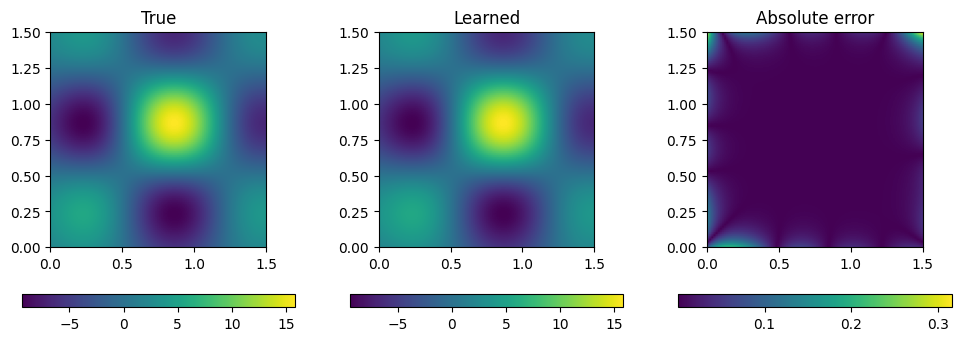

In [11]:
# Visualize predictions of u
data = {"True": u_test,
        "Learned": u_pred,
        "Absolute error": np.abs(u_test - u_pred.ravel())}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")